In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()
#

,amount,fee,n_backs,n_fees,n_incidents,transfer_type_regular,category_nice,category_rejected_direct_debit
0,1.0,0.0,0,0,1,1,0,0
1,100.0,0.0,1,0,0,1,0,0


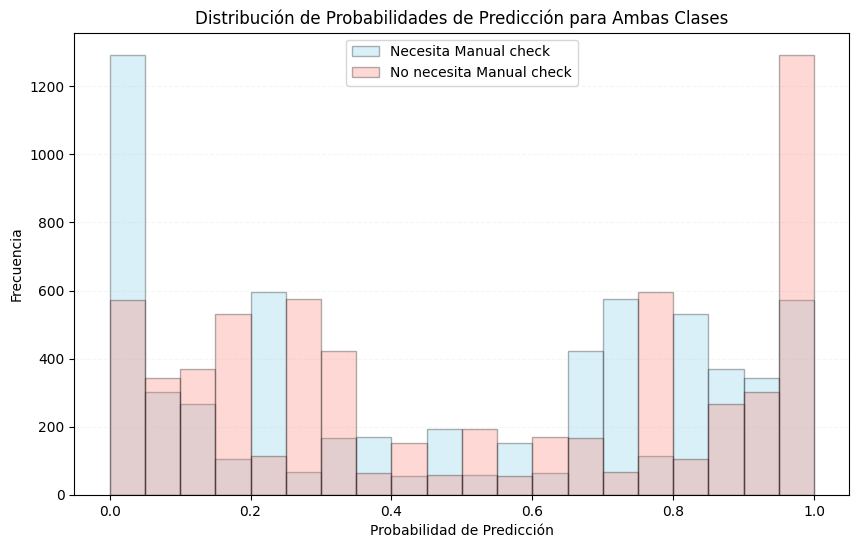

predicciones_probabilidades:
 [[0.72651301 0.27348699]
 [0.20104585 0.79895415]
 [0.04018046 0.95981954]
 [0.9869214  0.0130786 ]
 [0.00617812 0.99382188]
 [0.38505853 0.61494147]
 [0.80555423 0.19444577]
 [0.0015426  0.9984574 ]
 [0.09495649 0.90504351]
 [0.60663329 0.39336671]]

Coeficientes del modelo de regresión logística (ordenados por magnitud):
category_nice: -4.0192
category_rejected_direct_debit: 2.9248
n_incidents: 1.1487
n_fees: -0.9570
fee: 0.8150
n_backs: -0.7965
transfer_type_regular: -0.6429
amount: 0.0109


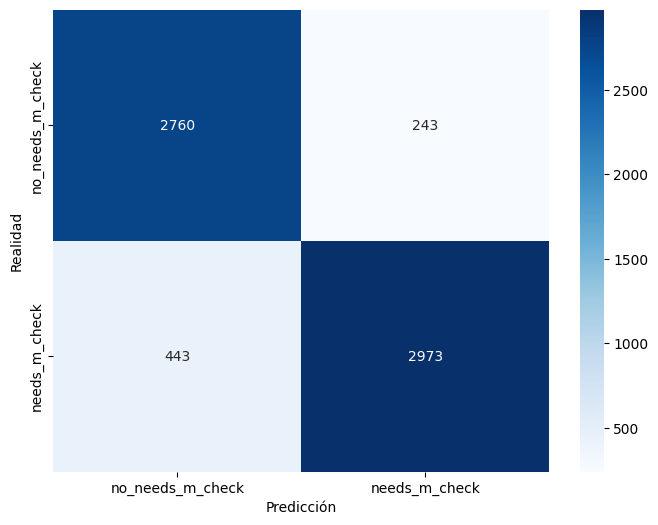

Accuracy: 0.8931297709923665
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      3003
           1       0.92      0.87      0.90      3416

    accuracy                           0.89      6419
   macro avg       0.89      0.89      0.89      6419
weighted avg       0.90      0.89      0.89      6419



In [6]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
columnas = ['amount','fee','n_backs','n_fees','n_incidents', 'transfer_type','category']
X = df[columnas].copy()
# Categoricas
X = pd.get_dummies(X, columns=['transfer_type', 'category'], drop_first=True, dtype =int)

y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))

feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report    